In [3]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46327,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:41203,Total threads: 8
Dashboard: http://127.0.0.1:38893/status,Memory: 83.91 GiB
Nanny: tcp://127.0.0.1:34695,


In [5]:
import xarray as xr
import pandas as pd

profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_ADCP.nc'
ds_adcp = xr.open_dataset(profile_path)
profile_path = '/data/shared_data/Interp_Profiles/regional/TP/TAO/TAO_WO_2012_CUR.nc'
ds_cur = xr.open_dataset(profile_path)

# Combine date and time into a datetime array
dates = ds_adcp['prof_YYYYMMDD'].values.astype(int)
times = ds_adcp['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_adcp = ds_adcp.assign_coords(time=('iPROF', datetimes))
# ds_adcp = ds_adcp.swap_dims({'iPROF': 'time'})
ds_adcp = ds_adcp.assign_coords(depth=('iDEPTH', ds_adcp['prof_depth'].values*-1))
# ds_adcp = ds_adcp.swap_dims({'iDEPTH': 'depth'})
ds_adcp = ds_adcp.assign_coords(lat=('iPROF', ds_adcp['prof_lat'].values))
ds_adcp = ds_adcp.assign_coords(lon=('iPROF', ds_adcp['prof_lon'].values))
# ds_adcp.set_index(lat='lat', lon='lon')
# Combine date and time into a datetime array
dates = ds_cur['prof_YYYYMMDD'].values.astype(int)
times = ds_cur['prof_HHMMSS'].values.astype(int)

# Convert to zero-padded strings
date_strs = dates.astype(str)
time_strs = times.astype(str)
time_strs = [t.zfill(6) for t in time_strs]  # ensure time is like 'HHMMSS'
# Combine into full datetime strings and convert to pandas datetime
datetime_strs = [d + t for d, t in zip(date_strs, time_strs)]
datetimes = pd.to_datetime(datetime_strs, format='%Y%m%d%H%M%S')

# Assign as coordinate and optionally swap dimensions
ds_cur = ds_cur.assign_coords(time=('iPROF', datetimes))
# ds_cur = ds_cur.swap_dims({'iPROF': 'time'})
ds_cur = ds_cur.assign_coords(depth=('iDEPTH', ds_cur['prof_depth'].values*-1))
# ds_cur = ds_cur.swap_dims({'iDEPTH': 'depth'})
ds_cur = ds_cur.assign_coords(lat=('iPROF', ds_cur['prof_lat'].values))
ds_cur = ds_cur.assign_coords(lon=('iPROF', ds_cur['prof_lon'].values))
# ds_cur.set_index(lat='lat', lon='lon')

adcp_by_lon = ds_adcp.groupby('lon')
cur_by_lon = ds_cur.groupby('lon')


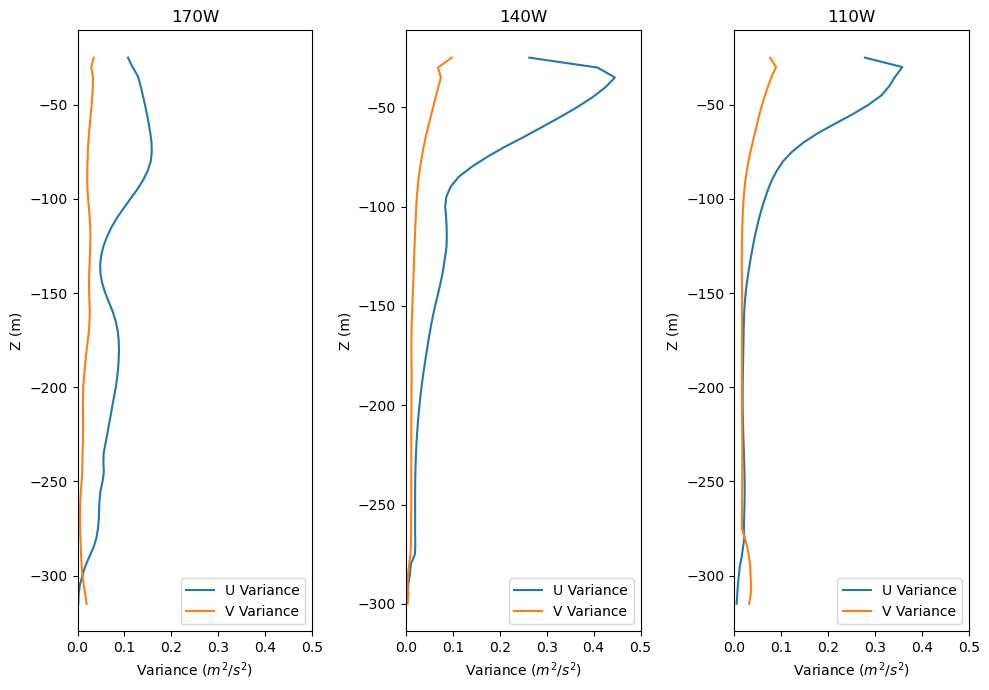

In [36]:
from matplotlib import pyplot as plt



fig, ax = plt.subplots(figsize=(10, 7),ncols=3)
u_var_170 = adcp_by_lon[190.0].where(adcp_by_lon[190.0].prof_U != -9999).prof_U.var(dim='iPROF',skipna=True)
v_var_170 = adcp_by_lon[190.0].where(adcp_by_lon[190.0].prof_V != -9999).prof_V.var(dim='iPROF',skipna=True)
ax[0].plot(u_var_170, ds_adcp.depth, label='U Variance')
ax[0].plot(v_var_170, ds_adcp.depth, label='V Variance')
ax[0].legend(loc='lower right')
ax[0].set_title('170W')
ax[0].set_xlabel('Variance ($m^2/s^2$)') 
ax[0].set_ylabel('Z (m)')
ax[0].set_xlim(0.0, 0.5)

u_var_140 = adcp_by_lon[220.0].where(adcp_by_lon[220.0].prof_U != -9999).prof_U.var(dim='iPROF',skipna=True)
v_var_140 = adcp_by_lon[220.0].where(adcp_by_lon[220.0].prof_V != -9999).prof_V.var(dim='iPROF',skipna=True)
ax[1].plot(u_var_140, ds_adcp.depth, label='U Variance')
ax[1].plot(v_var_140, ds_adcp.depth, label='V Variance')
ax[1].legend(loc='lower right')
ax[1].set_title('140W')
ax[1].set_xlim(0.0, 0.5)
ax[1].set_xlabel('Variance ($m^2/s^2$)') 
ax[1].set_ylabel('Z (m)')

u_var_110 = adcp_by_lon[250.0].where(adcp_by_lon[250.0].prof_U != -9999).prof_U.var(dim='iPROF',skipna=True)
v_var_110 = adcp_by_lon[250.0].where(adcp_by_lon[250.0].prof_V != -9999).prof_V.var(dim='iPROF',skipna=True)
ax[2].plot(u_var_110, ds_adcp.depth, label='U Variance')
ax[2].plot(v_var_110, ds_adcp.depth, label='V Variance')
ax[2].legend(loc='lower right')
ax[2].set_title('110W')
ax[2].set_xlim(0.0, 0.5)
ax[2].set_xlabel('Variance ($m^2/s^2$)') 
ax[2].set_ylabel('Z (m)')


plt.tight_layout()
plt.savefig('ADCP_Var.png')

In [2]:
client.shutdown()